In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

In [2]:
df = pd.read_csv('pv_data.csv')
df.head()

,hour_of_day,sunposition_thetaZ,sunposition_solarAzimuth,WindComponentUat0,WindComponentVat0,DewpointTemperatureAt0,TemperatureAt0,RelativeHumidityAt0,SolarRadiationGlobalAt0,TotalCloudCoverAt0,power_normed
0,0.000000,1.000000,0.250553,0.425266,0.653892,0.654981,0.426538,0.897686,0.000000,0.968750,0.000000
1,0.142857,1.000000,0.250817,0.407160,0.750980,0.661824,0.434919,0.892039,0.000000,1.000000,0.000000
2,0.285714,1.000000,0.251081,0.544557,0.667997,0.597057,0.399884,0.831692,0.000000,1.000000,0.000000
3,0.428571,0.708461,0.379841,0.688942,0.657905,0.598159,0.406052,0.818583,0.057197,0.976562,0.035185
4,0.571429,0.642045,0.555848,0.761857,0.593752,0.559800,0.407030,0.728758,0.244397,0.703125,0.120988


In [5]:
df['power_normed'].interpolate(method='linear', inplace=True)
values = df.values
values.shape

(18805, 11)

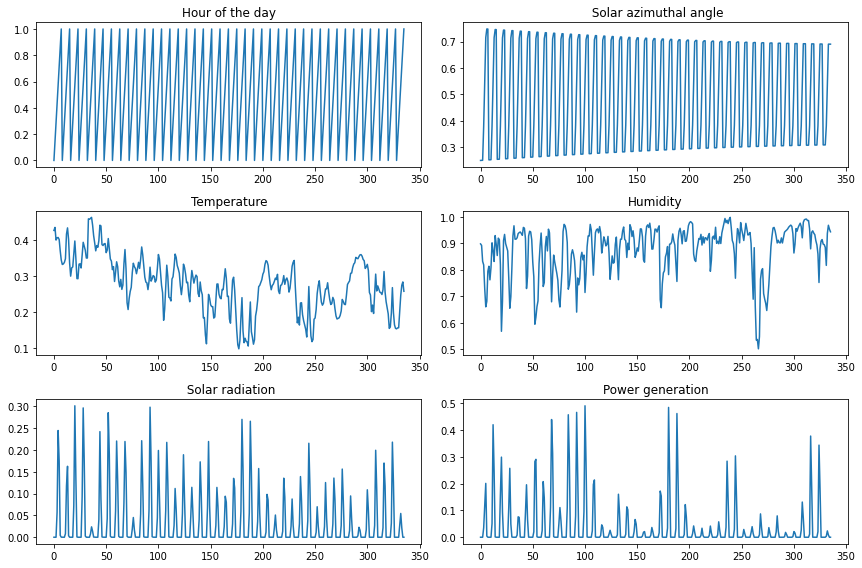

In [6]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(3, 2, figsize=(12,8))

axs[0,0].plot(values[0:336,0])
axs[0,0].set_title('Hour of the day')
axs[0,1].plot(values[0:336,2])
axs[0,1].set_title(' Solar azimuthal angle')
axs[1,0].plot(values[0:336,6])
axs[1,0].set_title('Temperature')
axs[1,1].plot(values[0:336,7])
axs[1,1].set_title('Humidity')
axs[2,0].plot(values[0:336,8])
axs[2,0].set_title(' Solar radiation')
axs[2,1].plot(values[0:336,10])
axs[2,1].set_title('Power generation')

fig.tight_layout()

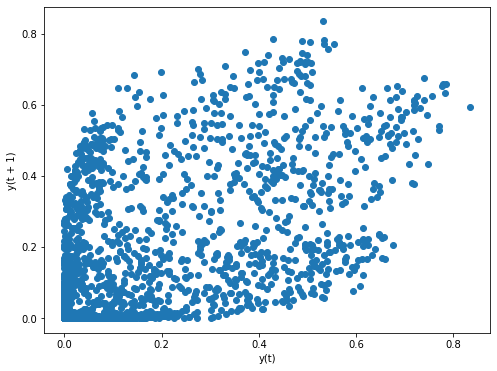

In [7]:
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import lag_plot
plt.figure(figsize = (8, 6))
series = df.iloc[2000:5000,10]
lag_plot(series)
pyplot.show()

<Figure size 576x432 with 0 Axes>

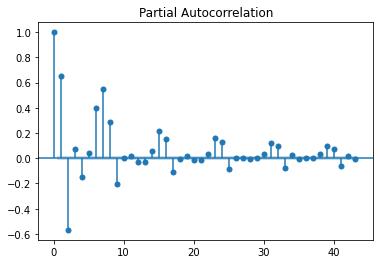

In [8]:
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
plt.figure(figsize = (8, 6))
series1 = df.iloc[:,10]
plot_pacf(series1)
pyplot.show()

In [9]:
def wind_vel(arr1,arr2):
    velocity=np.sqrt(np.square(arr1)+np.square(arr2))
    return velocity
wind_velocity=wind_vel(values[:,3],values[:,4])
df.insert(loc=3, column='wind_velocity', value=wind_velocity)
print(df.shape)
df.head()

(18805, 12)


,hour_of_day,sunposition_thetaZ,sunposition_solarAzimuth,wind_velocity,WindComponentUat0,WindComponentVat0,DewpointTemperatureAt0,TemperatureAt0,RelativeHumidityAt0,SolarRadiationGlobalAt0,TotalCloudCoverAt0,power_normed
0,0.000000,1.000000,0.250553,0.780017,0.425266,0.653892,0.654981,0.426538,0.897686,0.000000,0.968750,0.000000
1,0.142857,1.000000,0.250817,0.854255,0.407160,0.750980,0.661824,0.434919,0.892039,0.000000,1.000000,0.000000
2,0.285714,1.000000,0.251081,0.861836,0.544557,0.667997,0.597057,0.399884,0.831692,0.000000,1.000000,0.000000
3,0.428571,0.708461,0.379841,0.952618,0.688942,0.657905,0.598159,0.406052,0.818583,0.057197,0.976562,0.035185
4,0.571429,0.642045,0.555848,0.965903,0.761857,0.593752,0.559800,0.407030,0.728758,0.244397,0.703125,0.120988


In [10]:
dfn=df.drop(['WindComponentUat0', 'WindComponentVat0'], axis=1)
print(dfn.shape)
dfn.head()

(18805, 10)


,hour_of_day,sunposition_thetaZ,sunposition_solarAzimuth,wind_velocity,DewpointTemperatureAt0,TemperatureAt0,RelativeHumidityAt0,SolarRadiationGlobalAt0,TotalCloudCoverAt0,power_normed
0,0.000000,1.000000,0.250553,0.780017,0.654981,0.426538,0.897686,0.000000,0.968750,0.000000
1,0.142857,1.000000,0.250817,0.854255,0.661824,0.434919,0.892039,0.000000,1.000000,0.000000
2,0.285714,1.000000,0.251081,0.861836,0.597057,0.399884,0.831692,0.000000,1.000000,0.000000
3,0.428571,0.708461,0.379841,0.952618,0.598159,0.406052,0.818583,0.057197,0.976562,0.035185
4,0.571429,0.642045,0.555848,0.965903,0.559800,0.407030,0.728758,0.244397,0.703125,0.120988


In [11]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1)
    return df

In [12]:
NON_DER = []
df_new = df_derived_by_shift(dfn, 8, NON_DER)

In [13]:
df_new = df_new.dropna()

In [14]:
df_new.head()

,hour_of_day,sunposition_thetaZ,sunposition_solarAzimuth,wind_velocity,DewpointTemperatureAt0,TemperatureAt0,RelativeHumidityAt0,SolarRadiationGlobalAt0,TotalCloudCoverAt0,power_normed,...,TotalCloudCoverAt0_7,TotalCloudCoverAt0_8,power_normed_1,power_normed_2,power_normed_3,power_normed_4,power_normed_5,power_normed_6,power_normed_7,power_normed_8
8,0.000000,1.000000,0.252655,0.892591,0.514629,0.332251,0.813337,0.000000,0.320312,0.000000,...,1.000000,0.968750,0.000000,0.004321,0.201235,0.120988,0.035185,0.000000,0.000000,0.000000
9,0.142857,1.000000,0.252917,0.812328,0.494087,0.333745,0.762055,0.000000,1.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,0.004321,0.201235,0.120988,0.035185,0.000000,0.000000
10,0.285714,1.000000,0.253177,0.893604,0.518971,0.338093,0.808486,0.000000,1.000000,0.000000,...,0.976562,1.000000,0.000000,0.000000,0.000000,0.004321,0.201235,0.120988,0.035185,0.000000
11,0.428571,0.713414,0.380225,1.029958,0.570053,0.348251,0.901725,0.008139,1.000000,0.051235,...,0.703125,0.976562,0.000000,0.000000,0.000000,0.000000,0.004321,0.201235,0.120988,0.035185
12,0.571429,0.647150,0.555611,0.958414,0.632471,0.416335,0.871612,0.117516,0.898438,0.420576,...,0.421875,0.703125,0.051235,0.000000,0.000000,0.000000,0.000000,0.004321,0.201235,0.120988


In [15]:
df_new.columns.values

array(['hour_of_day', 'sunposition_thetaZ', 'sunposition_solarAzimuth',
       'wind_velocity', 'DewpointTemperatureAt0', 'TemperatureAt0',
       'RelativeHumidityAt0', 'SolarRadiationGlobalAt0',
       'TotalCloudCoverAt0', 'power_normed', 'hour_of_day_1',
       'hour_of_day_2', 'hour_of_day_3', 'hour_of_day_4', 'hour_of_day_5',
       'hour_of_day_6', 'hour_of_day_7', 'hour_of_day_8',
       'sunposition_thetaZ_1', 'sunposition_thetaZ_2',
       'sunposition_thetaZ_3', 'sunposition_thetaZ_4',
       'sunposition_thetaZ_5', 'sunposition_thetaZ_6',
       'sunposition_thetaZ_7', 'sunposition_thetaZ_8',
       'sunposition_solarAzimuth_1', 'sunposition_solarAzimuth_2',
       'sunposition_solarAzimuth_3', 'sunposition_solarAzimuth_4',
       'sunposition_solarAzimuth_5', 'sunposition_solarAzimuth_6',
       'sunposition_solarAzimuth_7', 'sunposition_solarAzimuth_8',
       'wind_velocity_1', 'wind_velocity_2', 'wind_velocity_3',
       'wind_velocity_4', 'wind_velocity_5', 'wind_veloc

In [16]:
corr=df_new.corr()
corr_arr=corr.values
print(corr_arr.shape)

(90, 90)


<AxesSubplot:>

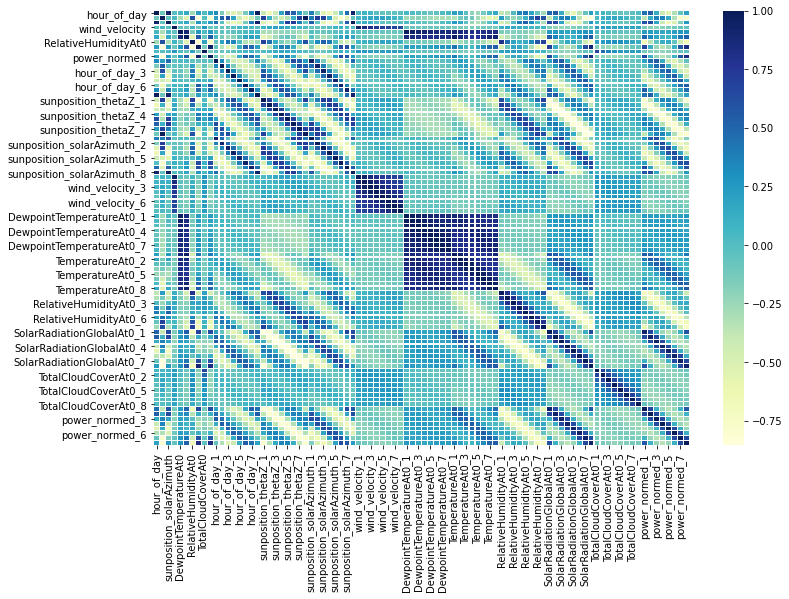

In [17]:
import seaborn as sns
f, ax = plt.subplots(figsize =(12,8))
sns.heatmap(corr, ax = ax, cmap ="YlGnBu", linewidths = 0.1)

In [18]:
X=df_new[['hour_of_day', 'sunposition_thetaZ', 'sunposition_solarAzimuth',
       'wind_velocity', 'DewpointTemperatureAt0', 'TemperatureAt0',
       'RelativeHumidityAt0', 'SolarRadiationGlobalAt0',
       'TotalCloudCoverAt0','power_normed_1',
       'power_normed_2', 'power_normed_3', 'power_normed_4',
       'power_normed_5', 'power_normed_6', 'power_normed_7',
       'power_normed_8']]

In [19]:
y=df_new[['power_normed']]

In [20]:
xval=X.values
xval.shape

(18797, 17)

In [21]:
yval=y.values

In [22]:
yval=yval.reshape((yval.shape[0],1))

In [23]:
yval.shape

(18797, 1)

In [24]:
data=np.concatenate((xval,yval), axis=1)
data.shape

(18797, 18)

In [25]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, .1))
# scaled = scaler.fit_transform(data)

In [26]:
scaled=data
print(scaled)

[[0.00000000e+00 1.00000000e+00 2.52655325e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.42857143e-01 1.00000000e+00 2.52916569e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.85714286e-01 1.00000000e+00 2.53177474e-01 ... 3.51851850e-02
  0.00000000e+00 0.00000000e+00]
 ...
 [8.57142857e-01 1.00000000e+00 6.95528082e-01 ... 0.00000000e+00
  0.00000000e+00 2.46000000e-04]
 [1.00000000e+00 1.00000000e+00 6.95596228e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 3.04335219e-01 ... 0.00000000e+00
  0.00000000e+00 1.71932700e-03]]


In [27]:
# split into train and test sets
n_train_hours = len(scaled)-56
train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, 0:216], train[:, -1]
test_X, test_y = test[:, 0:216], test[:, -1]
# # reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
test_X = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(18741, 18, 1) (18741,) (56, 18, 1) (56,)


In [28]:
test_y

array([0.        , 0.        , 0.00712293, 0.05157982, 0.01424585,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00638607, 0.10708952, 0.08301894, 0.000246  , 0.        ,
       0.        , 0.        , 0.        , 0.01007034, 0.09112434,
       0.05870274, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00785978, 0.10045783, 0.0567378 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01522833,
       0.11519492, 0.05772027, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00147371, 0.02603553, 0.0216144 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01522833, 0.02112316, 0.000246  , 0.        ,
       0.00171933])

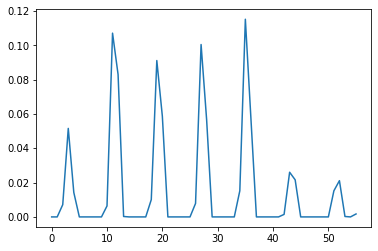

In [29]:
plt.plot(test_y)

In [32]:
train_y2=train_y.reshape(train_y.shape[0],1)
test_y2=test_y.reshape(test_y.shape[0],1)
n_features = 1
n_seq = 6
n_steps = 3
train_X2 = train_X.reshape((train_X.shape[0], n_seq, 1, n_steps, n_features))
test_X2= test_X.reshape((test_X.shape[0], n_seq, 1, n_steps, n_features))
print(train_X2.shape, train_y2.shape, test_X2.shape, test_y2.shape)

(18741, 6, 1, 3, 1) (18741, 1) (56, 6, 1, 3, 1) (56, 1)


In [33]:
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
model2 = Sequential()
model2.add(ConvLSTM2D(filters=50, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model2.add(Flatten())
model2.add(Dense(1))
model2.compile(optimizer='adam', loss='mse')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 2, 50)          20600     
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 20,701
Trainable params: 20,701
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = model2.fit(train_X2, train_y2, epochs = 20, shuffle=False, validation_split = 0.2, batch_size = 16)

Epoch 1/20
937/937 [==============================] - 6s 7ms/step - loss: 1.0821e-04 - val_loss: 1.0734e-04
Epoch 2/20
937/937 [==============================] - 6s 7ms/step - loss: 5.5470e-05 - val_loss: 5.4471e-05
Epoch 3/20
937/937 [==============================] - 6s 7ms/step - loss: 3.2518e-05 - val_loss: 4.3655e-05
Epoch 4/20
937/937 [==============================] - 6s 7ms/step - loss: 1.9682e-05 - val_loss: 1.5481e-05
Epoch 5/20
937/937 [==============================] - 6s 7ms/step - loss: 1.2851e-05 - val_loss: 1.9214e-05
Epoch 6/20
937/937 [==============================] - 6s 7ms/step - loss: 7.3202e-06 - val_loss: 8.0832e-06
Epoch 7/20
937/937 [==============================] - 6s 6ms/step - loss: 5.8403e-06 - val_loss: 5.0438e-06
Epoch 8/20
937/937 [==============================] - 6s 6ms/step - loss: 6.0600e-06 - val_loss: 3.9049e-06: 0s - loss
Epoch 9/20
937/937 [==============================] - 6s 6ms/step - loss: 5.5493e-06 - val_loss: 2.9245e-06
Epoch 10/20
937/9

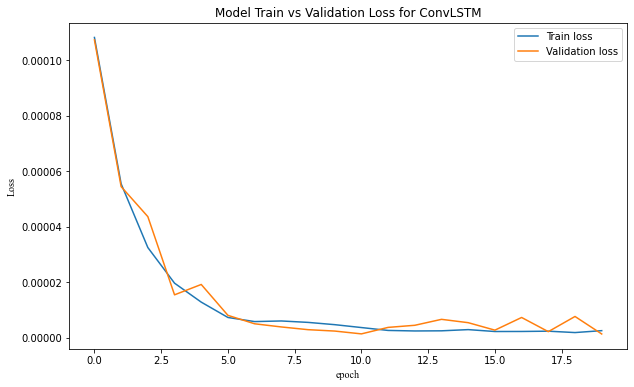

In [36]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    csfont = {'fontname':'Times New Roman'}
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for'+ model_name)
    plt.ylabel('Loss',**csfont)
    plt.xlabel('epoch',**csfont)
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
 
plot_loss (history, ' ConvLSTM')

In [39]:
# Make prediction
def prediction(model):
    prediction = model.predict(test_X2)
#     prediction = scaler.inverse_transform(prediction)
    return prediction
prediction_Convlstm = prediction(model2)
prediction_Convlstm

array([[-5.4072402e-04],
       [-2.7722679e-04],
       [ 6.4244512e-03],
       [ 5.0632454e-02],
       [ 1.3389910e-02],
       [-1.1769142e-03],
       [-9.6253119e-04],
       [ 2.0260550e-04],
       [-2.7739070e-04],
       [-4.6438538e-04],
       [ 6.1233733e-03],
       [ 1.0611942e-01],
       [ 8.2945921e-02],
       [ 2.7025118e-05],
       [-9.1081485e-05],
       [-6.1756000e-05],
       [-5.2157603e-04],
       [-1.4233496e-03],
       [ 9.0260003e-03],
       [ 9.0943597e-02],
       [ 5.7897739e-02],
       [-6.4303540e-04],
       [-4.1135214e-04],
       [ 2.3778714e-04],
       [-3.6919676e-04],
       [-3.1006895e-04],
       [ 7.3023532e-03],
       [ 9.9846102e-02],
       [ 5.6587331e-02],
       [-6.1177276e-04],
       [-4.9462542e-05],
       [ 2.0737387e-04],
       [-1.8244050e-04],
       [-7.5564347e-04],
       [ 1.4443601e-02],
       [ 1.1428306e-01],
       [ 5.7008751e-02],
       [-1.0665115e-03],
       [-1.0798480e-03],
       [-7.8505836e-04],


In [40]:
prediction_Convlstm.shape

(56, 1)

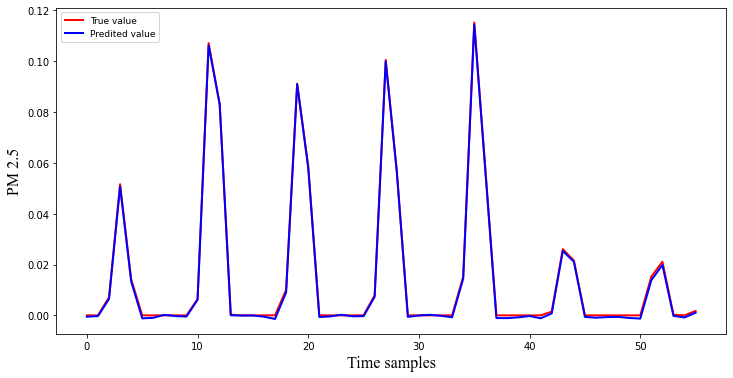

In [41]:
plt.figure(figsize=(12,6))
csfont = {'fontname':'Times New Roman'}
plt.ylabel('PM 2.5',fontsize=16,**csfont)
plt.xlabel('Time samples',fontsize=16,**csfont)
plt.plot(test_y2,c='r',linewidth=2)
plt.plot(prediction_Convlstm,c='b',linewidth=2)
plt.legend(['True value','Predited value'], loc='upper left',fontsize=9)

In [43]:
def evaluate_prediction(predictions, actual, model_name):
    dif=predictions-actual
    errors = np.nan_to_num(dif, nan=0)
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Square Error: {:.4f}'.format(mse))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Mean Absolute  Error: {:.4f}'.format(mae))
    return errors, mse, rmse, mae

errors, mse, rmse, mae= evaluate_prediction(test_y2,prediction_Convlstm, 'Bidirectiona LSTM')

Bidirectiona LSTM:
Mean Square Error: 0.0000
Root Mean Square Error: 0.0007
Mean Absolute  Error: 0.0006


In [44]:
import numpy as np

def mape(actual,pred):
    act=[]
    prd=[]
    for i in range(len(actual)):
        if actual[i]==0 or pred[i]==0:
            pass
        else:
            act.append(actual[i])
            prd.append(pred[i])
        
    actual, pred = np.array(act), np.array(prd)
    mp=np.mean(np.abs((actual - pred) / actual))
    return mp

In [45]:
MAPE_scaled=mape(test_y,prediction_bilstm)
MAPE_scaled

NameError: name 'prediction_bilstm' is not defined